## Simulação de Monte Carlo

Nesse notebook é realizada a Simulção de Monte Carlo das emissões evitadas pela eletrificação da frota

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.load_csv import load_csv

In [2]:
gdf = load_csv("gdf_final.csv")
df_diesel = gdf[gdf["is_eletrico"] == False].copy()

In [3]:
def sim_monte_carlo(df_diesel, Y, N=2000, seed=42):
    np.random.seed(seed)
    resultados = []

    for _ in range(N):
        amostra = df_diesel.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados.append(emissao_total)

    impacto_medio = np.mean(resultados)
    impacto_maximo = df_diesel.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio
    IC_inf = np.percentile(resultados, 2.5)
    IC_sup = np.percentile(resultados, 97.5)

    return {
        "Y": Y,
        "impacto_medio": impacto_medio,
        "IC_inf": IC_inf,
        "IC_sup": IC_sup,
        "impacto_maximo": impacto_maximo,
        "impacto_diferenca": impacto_diferenca,
        "resultados": resultados
    }

In [4]:
tamanhos_frota = [50, 100, 200]
res = [sim_monte_carlo(df_diesel, y) for y in tamanhos_frota]

In [5]:
tabela_resumo = pd.DataFrame([
    {
        "Tamanho da frota substituída (Y)": r["Y"],
        "Emissão média evitada (t CO₂/dia)": r["impacto_medio"],
        "IC95% inferior": r["IC_inf"],
        "IC95% superior": r["IC_sup"],
        "Cenário máximo (t CO₂/dia)": r["impacto_maximo"],
        "Diferença (Máx - Média)": r["impacto_diferenca"]
    }
    for r in res
])

tabela_resumo = tabela_resumo.round(5)
tabela_resumo = tabela_resumo.sort_values(by="Tamanho da frota substituída (Y)")

print("\nResumo dos resultados da Simulação de Monte Carlo")
print("=" * 90)
display(tabela_resumo)


Resumo dos resultados da Simulação de Monte Carlo


,Tamanho da frota substituída (Y),Emissão média evitada (t CO₂/dia),IC95% inferior,IC95% superior,Cenário máximo (t CO₂/dia),Diferença (Máx - Média)
0,50,0.00813,0.00384,0.02853,1.58028,1.57215
1,100,0.01631,0.00922,0.04323,2.61569,2.59938
2,200,0.03249,0.02062,0.06753,3.93959,3.90710


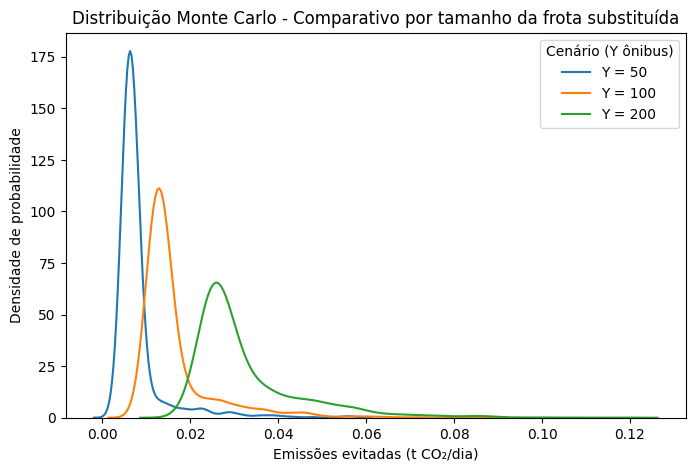

In [6]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}")
plt.xlabel("Emissões evitadas (t CO₂/dia)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.show()

In [ ]:
df_posicoes = load_csv("")

df_posicoes.head()

,hora_requisicao,codigo_linha,nome_linha,letreiro,codigo_onibus,x,y,hora_gps
0,14:02:00,1036,3736-10,METRÔ ARTUR ALVIM - JD. NSA. SRA. DO CARMO,47238,-46.474936,-23.558874,2025-10-16 17:02:00+00:00
1,14:02:00,1036,3736-10,METRÔ ARTUR ALVIM - JD. NSA. SRA. DO CARMO,47745,-46.482555,-23.549962,2025-10-16 17:01:59+00:00
2,14:02:00,1036,3736-10,METRÔ ARTUR ALVIM - JD. NSA. SRA. DO CARMO,47197,-46.483761,-23.542164,2025-10-16 17:02:17+00:00
3,14:02:00,1036,3736-10,METRÔ ARTUR ALVIM - JD. NSA. SRA. DO CARMO,47269,-46.483413,-23.575533,2025-10-16 17:02:16+00:00
4,14:02:00,1036,3736-10,METRÔ ARTUR ALVIM - JD. NSA. SRA. DO CARMO,47185,-46.483096,-23.577528,2025-10-16 17:02:37+00:00
